In [2]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.optimizers import Adam
from tqdm import trange
from random import sample
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:

GAMMA = 0.99
LEARNING_RATE = 2.5e-4

MEMORY_SIZE = 1000000
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [5]:
state_space=8
obs_space=5
action_space=4
intermediate_dim=16

In [6]:
env = gym.make('LunarLander-v2',
    continuous= False,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power= 0.5,)


In [7]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(Dense(512, input_dim = self.input_dim, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer = RMSprop(lr = self.lr, rho = 0.95, epsilon = 0.01), loss = "mse", metrics = ['accuracy'])
        return model

In [8]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.99975, 
                  memory_size = 10_000,  C = 5):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=0.98
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            action = np.argmax(self.model.Qpolicy.predict(states))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            qvalue = self.model.Qpolicy.predict(s)[0]
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            future_qvalue = self.model.Qtarget.predict(s_)[0]

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget                
                X.append(state)
                y.append(qcurr)
                
            X, y = np.array(X).reshape(1,self.batch_size,1,self.states), np.array(y).reshape(1,self.batch_size, 1, self.n_actions)
                                        
            loss = self.model.Qpolicy.fit(X, y, batch_size = self.batch_size, shuffle = False, verbose = 0)
            #self.history.append(loss.history['loss'][0])
            
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [9]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(7,))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [10]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, input_features,var):
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=[]
      for i in range(len(input_features)):
          temp.append(tf.concat((input_features[i],var[i]),axis=1))
      temp=tf.convert_to_tensor(temp)
      activation1 = self.hidden_layer1(temp)
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [12]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(intermediate_dim=intermediate_dim,state_space=state_space)
    
    self.decoder = Decoder(
      intermediate_dim=intermediate_dim,
      obs_space=obs_space
    )
    
  
  def call(self, input_features,var):
    code = self.encoder(input_features)
    #self.var=tf.Variable(var,trainable=False)
    reconstructed = self.decoder(code,var)
    return reconstructed


opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [13]:

def loss(model,input_features, obs,var):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(input_features,var), obs)))
  return reconstruction_error
  
def train(loss, model, opt,input_features,obs,var):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model,input_features, obs,var), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

In [14]:
obs=env.reset()
obs

(array([-1.3489723e-03,  1.4211508e+00, -1.3652802e-01,  4.5469943e-01,
         1.4605763e-03,  2.8788839e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

In [15]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)


In [16]:
def get_obs(state):
    return [state[0],state[1],state[4],state[6],state[7]]

In [17]:
def data_collection(total_episodes,dqn_solver,autoencoder,maxt=1000):

    S_series=[]
    S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    encoder=autoencoder.encoder
    decoder=autoencoder.decoder

    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        
        #s0=np.reshape(s0,[1,state_space])
        
        step=0
        done=False
        for t in range(maxt):
            if(step==0):
                s=s0
                S_actual_series.append(s)
            else:
                s=encoder(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            
            action=dqn_solver.act(s)

            actual_state, reward, done,_,_ = env.step(int(action))
            obs=get_obs(actual_state)
            Done_series.append(done)
            actual_state=np.reshape(actual_state,[1,state_space])
            S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred=decoder(s,action)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            if(done==True):
                break
        ep_no+=1
    return S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series


In [18]:
def dqn_training(dqn_solver,epochs,S_series,U_series,R_series,Done_series):
    dqn_solver.forget()
    for i in range(len(S_series)-1):
        dqn_solver.remember(S_series[i][0],U_series[i][0][0],R_series[i],S_series[i+1][0],Done_series[i])
    for j in trange(epochs):
        dqn_solver.train()
        if(j%20==0):
            dqn_solver.update_target_model()

In [19]:
def autoencoder_training(epochs,autoencoder,S_series,O_series,U_series):
    temp1=[]
    temp2=[]
    temp3=[]
    if(len(S_series)<15000):
        random_list=list(range(2,len(S_series)-1))
    else:
        random_list=sample(list(range(2,len(S_series)-1)),15000)
    for i in random_list:
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(10)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(10)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(10)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))
    
    for epoch in trange(epochs):
        for x in final_dataset:
            train(loss,autoencoder,opt,x[0],x[1],x[2])

In [20]:
rewards_storage=[]

In [21]:
S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series=data_collection(2,dqn_solver,autoencoder)

In [21]:
#env.step(int(U_series[2]))

In [27]:
R_series[3].shape

()

In [23]:
#S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series=data_collection(25,dqn_solver,autoencoder)


In [24]:
#autoencoder_training(2,autoencoder,S_series,O_series,U_series)

In [25]:
def complete_loop(autoencoder,dqn_solver,epochs):
    for epoch in range(epochs):
        S_series,O_series,U_series,R_series,O_predicted_series,S_actual_series,Done_series=data_collection(25,dqn_solver,autoencoder)
        print("epoch: {}, total reward: {}".format(epoch, sum(R_series)))
        rewards_storage.append(sum(R_series))
        if(epoch<250):
            if(epoch%2==0):
                iter=min(len(S_series),10000)

                dqn_training(dqn_solver,iter,S_series,U_series,R_series,Done_series)
                dqn_solver.decrement_epsilon()
                
            else:
                autoencoder_training(25,autoencoder,S_series,O_series,U_series)
        else:
            dqn_training(dqn_solver,10000,S_series,U_series,R_series,Done_series)
            dqn_solver.decrement_epsilon()

In [26]:
complete_loop(autoencoder,dqn_solver,100)

epoch: 0, total reward: -4944.043236170439


  0%|          | 0/3361 [00:00<?, ?it/s]

  1%|          | 25/3361 [00:12<21:24,  2.60it/s] Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000244AC0F0820>
Traceback (most recent call last):
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 
  2%|▏         | 66/3361 [00:28<17:20,  3.17it/s]

In [ ]:
# x=tf.concat((S_series[3-1],O_series[3],U_series[3-1]),axis=1)
# print(x)

In [ ]:
# print(loss(autoencoder,x,O_series[4],U_series[3]))

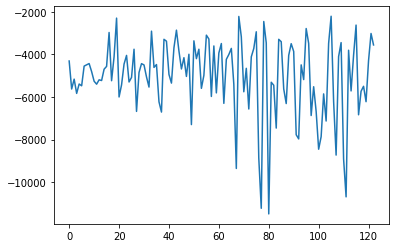

: 

In [ ]:
plt.plot(rewards_storage)

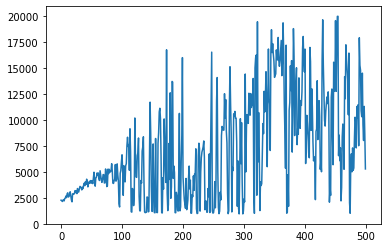

In [ ]:
plt.plot(rewards_storage)

In [ ]:
for i,val in enumerate(rewards_storage):
    if (val>10000):
        print("{} , {}".format(i,val))

121 , 10189.0
146 , 11714.0
161 , 10773.0
162 , 11126.0
163 , 10140.0
169 , 10097.0
173 , 16759.0
179 , 12613.0
182 , 13711.0
183 , 13648.0
194 , 10632.0
199 , 16007.0
246 , 10681.0
247 , 16537.0
255 , 11849.0
256 , 14087.0
268 , 12528.0
269 , 10161.0
270 , 11960.0
276 , 11379.0
277 , 15128.0
278 , 11453.0
283 , 10582.0
284 , 10393.0
285 , 10825.0
286 , 10160.0
287 , 10163.0
294 , 10119.0
302 , 14426.0
305 , 10515.0
308 , 12574.0
309 , 10590.0
310 , 10455.0
311 , 12544.0
312 , 11197.0
313 , 11598.0
314 , 11470.0
315 , 13999.0
318 , 15013.0
319 , 15991.0
320 , 16252.0
322 , 19465.0
324 , 10708.0
333 , 12763.0
334 , 10774.0
335 , 12134.0
336 , 14648.0
337 , 12109.0
339 , 11342.0
340 , 16837.0
341 , 11982.0
342 , 11534.0
344 , 16530.0
345 , 18696.0
346 , 16493.0
347 , 17350.0
348 , 16352.0
349 , 15688.0
350 , 14102.0
351 , 14334.0
352 , 14424.0
353 , 16752.0
354 , 15874.0
355 , 15780.0
356 , 17952.0
357 , 15763.0
358 , 15171.0
359 , 15713.0
360 , 16719.0
361 , 17666.0
362 , 14267.0
363 , 

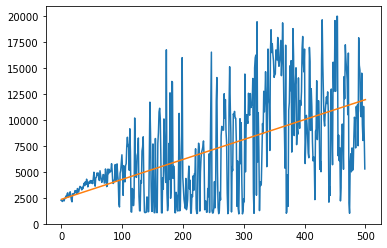

In [ ]:
y=rewards_storage
x=[float(i) for i in range (1,len(rewards_storage)+1)]
x=np.array(x)
m,b=np.polyfit(x,y,1)
plt.plot(rewards_storage)
plt.plot(x,m*x+b)

In [ ]:
import pandas as pd
df=pd.DataFrame(rewards_storage)
df.to_csv('rewards_2_main.csv')

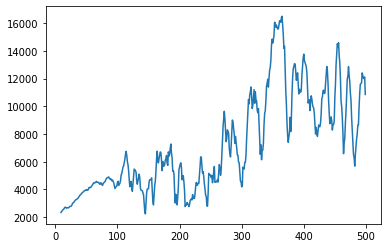

In [ ]:
df_avg=df.rolling(window=10).mean()
plt.plot(df_avg)